<a href="https://colab.research.google.com/github/SairajNeelam/CoronaVirus-Tweet-Sentiment-Analysis/blob/main/CoronaVirus_Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Problem Statement***

> **We have to build a classification model to predict the sentiment of Covid-19 tweets**.





### **What is sentiment analysis?**
**Sentiment analysis, also known as opinion mining, or emotion AI, boils down to one thing:**

> **It’s the process of analyzing online pieces of writing to determine the emotional tone they carry, whether they’re positive, negative, or neutral.**

>**In simple words, sentiment analysis helps to find the author’s attitude towards a topic. Sentiment analysis tools categorize pieces of writing as positive, neutral, or negative**.

### **Why sentiment analysis is important?**

1. **Sentiment analysis is important because emotions and attitudes towards a topic can become actionable pieces of information useful in numerous areas of business and research.**
2. **Text analytics and opinion mining find numerous applications in e-commerce, marketing, advertising, politics, market research and any other research, which is very helpful for businesses.**
3. **It saves time and effort. Assessing the tone they carry manually is doable, but takes ages.**

### **Approach for the problem:**

1. **Data Review**
2. **Text Pre-processing**
3. **Text Parsing and Exploratory Data Analysis**
4. **Text Representation and Feature Engineering**
5. **Modeling or Pattern Mining**
6. **Evaluation**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re # for regular expressions
# import pandas as pd 
# pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

## ***Data Review***

In [2]:
working_dir_path = '/content/drive/MyDrive/AlmaBetter/Capstone Project/Datasets/CoronaVirus Tweet Sentiment Analysis/Coronavirus Tweets.csv'
df = pd.read_csv(working_dir_path, encoding = 'latin')

In [3]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df.shape

(41157, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


> **We see that Location feature has null values and TweetAt feature must be in datetime format**

In [6]:
#defined a function to check Null/missing values in a dataframe

def check_Null(df):
    #Percentage of NAN Values 
    nan_df = [(col, df[col].isna().mean()*100) for col in df ]
    nan_df = pd.DataFrame(nan_df, columns=["column_name", "percentage"])

    #features with null values
    nan_df = nan_df[nan_df.percentage !=0]
    nan_df.sort_values("percentage", ascending=False)
    
    return nan_df

In [7]:
print("Missing Value Features : \n")
print(check_Null(df),"\n")

Missing Value Features : 

  column_name  percentage
2    Location   20.871298 



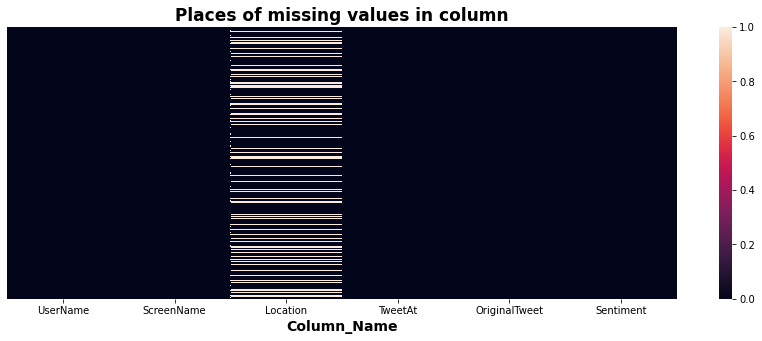

In [8]:
plt.figure(figsize=(15, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

> **We see that 20.87% of values from Location feature is missing**

> **Now let's see how many unique values are there in each feature**

In [9]:
#function def for displaying unique values for all features of dataframe 
def uniqueValuesForDf(df):
  unique_values = [(col , df[col].unique(),len(df[col].unique())) for col in df]
  unique_values = pd.DataFrame(unique_values, columns=["column_name", "Unique Values","Count of Unique values"])
  unique_values.sort_values(by=['Count of Unique values'])
  return unique_values

In [10]:
unique_values = uniqueValuesForDf(df)
unique_values

,column_name,Unique Values,Count of Unique values
0,UserName,"[3799, 3800, 3801, 3802, 3803, 3804, 3805, 380...",41157
1,ScreenName,"[48751, 48752, 48753, 48754, 48755, 48756, 487...",41157
2,Location,"[London, UK, Vagabonds, nan, ÃT: 36.319708,-8...",12221
3,TweetAt,"[16-03-2020, 17-03-2020, 18-03-2020, 19-03-202...",30
4,OriginalTweet,[@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/...,41157
5,Sentiment,"[Neutral, Positive, Extremely Negative, Negati...",5


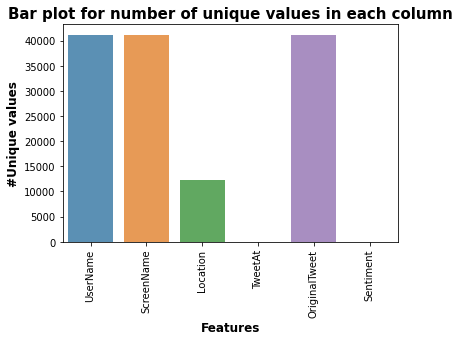

In [11]:
sns.barplot(x=unique_values['column_name'], y=unique_values['Count of Unique values'], alpha=0.8)
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

> **What we can tell is by looking at it is that the tweets collected are for short duration of time as only 30 unique values are there in the TweetAt feature, so let us explore later into it to get exact timeframe from which the tweets were collected**

> **Secondly, the tweets are categorized into 5 unique classes of sentiments**

> **Also, just by looking into Location feature we can see that we have some problems in it, as we can see some numerics in Location feature**

## ***Data Pre-processing***

In [12]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [13]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### **Feature ▶ TweetAt**

In [14]:
df['TweetAt'].value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [15]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')

In [16]:
df['TweetAt'].head()

0   2020-03-16
1   2020-03-16
2   2020-03-16
3   2020-03-16
4   2020-03-16
Name: TweetAt, dtype: datetime64[ns]

In [17]:
print(pd.DatetimeIndex(df['TweetAt']).year.value_counts(),"\n")
print('='*50)
print(pd.DatetimeIndex(df['TweetAt']).month.value_counts())

2020    41157
Name: TweetAt, dtype: int64 

3    25499
4    15658
Name: TweetAt, dtype: int64


> **So, the tweets are for the year 2020 and for only 2 months of March and April**

### **Feature ▶ OriginalTweet**

**For text data we need to do a bit different pre-processing:**

* **Tokenization**
* **Stop Words Removal**
* **Stemming/Lemmatization** 

**Before doing these we will first remove @username and all the links in the text**

**▶ Removing @username**

In [18]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [19]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [20]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX...
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV..."


**▶ Removing links**

In [21]:
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [22]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV..."


**▶ Clean the Text**

In [23]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

In [24]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [25]:
# get the stopwords of the english dictionary
stop = set(nltk.corpus.stopwords.words('english')) 

# get the punctuations from string library 
punctuations = string.punctuation

# we use WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
# ps = PorterStemmer()

In [26]:
def cleaning(text):
    
    # 1. Remove non-letters.
    letters = re.sub("[^a-zA-Z]", " ", text)
    # print(letters)
    # print('='*100)
    
    # 2. Convert to lower case.
    letters = letters.lower()
    
    # 3. Tokenize.
    tokens = nltk.word_tokenize(letters)
    # print(tokens)
    # print('='*100)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in tokens if not w in stops]
    # print(words)
    # print('='*100)

    # 6. Stemming using WordNetLemmatizer
    words = [lemmatizer.lemmatize(w) for w in words]
    # print(words)
    # print('='*100)
    
    # 7. Join the words back into one string separated by space, and return the result.
    return " ".join(words)

In [27]:
df['Tweet'] = [cleaning(x) for x in df['Tweet']]
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth give elderly d...
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak paranoid f...


## ***Exploratory Data Analysis***

### **Data Visualization of Tweets**

In [28]:
from wordcloud import WordCloud

**▶ For all words**

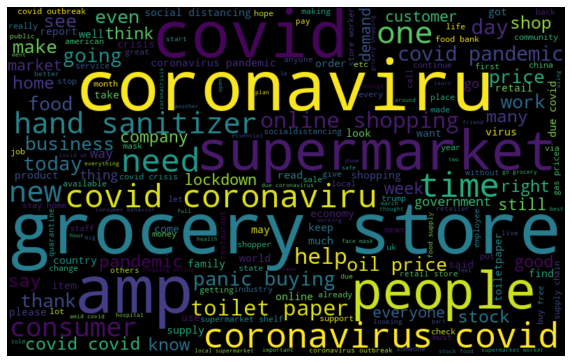

In [29]:
# create text from all tweets
all_words = ' '.join([text for text in df['Tweet']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

> **With just this simple WordCloud we can get a hint what people in these 41,000 tweets are talking about**

> **We see that words are popped up where mostly people are talking about grocery stores and supermarket for buying or shopping essential needs and also about online shopping**

> **We see the texts of hand sanitizer, toilet paper where the topic could be hygiene**

> **There are some tweets of panic buying, oil prices and the business**

In [30]:
vis_df = pd.DataFrame()

vis_df[['Tweet', 'Sentiment']] = df[['Tweet', 'Sentiment']]

In [31]:
vis_df.head()

,Tweet,Sentiment
0,,Neutral
1,advice talk neighbour family exchange phone nu...,Positive
2,coronavirus australia woolworth give elderly d...,Positive
3,food stock one empty please panic enough food ...,Positive
4,ready go supermarket covid outbreak paranoid f...,Extremely Negative


In [32]:
# let us combine positive and extremely positive in one group and negative and extremely negative in other for the sake of visualization

vis_df['Sentiment'] = vis_df['Sentiment'].apply(lambda x: x.replace('Extremely Positive', 'Positive'))
vis_df['Sentiment'] = vis_df['Sentiment'].apply(lambda x: x.replace('Extremely Negative', 'Negative'))
vis_df.head()

,Tweet,Sentiment
0,,Neutral
1,advice talk neighbour family exchange phone nu...,Positive
2,coronavirus australia woolworth give elderly d...,Positive
3,food stock one empty please panic enough food ...,Positive
4,ready go supermarket covid outbreak paranoid f...,Negative


**▶ For positive words**

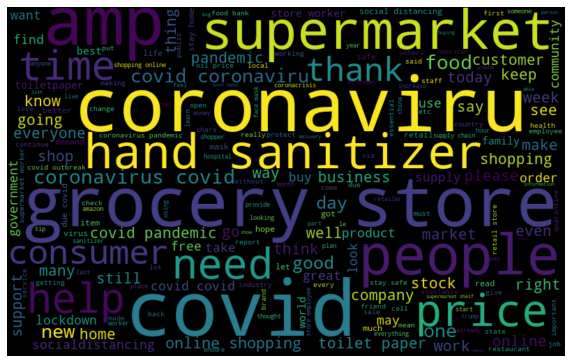

In [33]:
# create text from just normal tweets
positive_words = ' '.join([text for text in vis_df['Tweet'][vis_df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

> **Here we see some words about Hand Santitizer, Consumer, Supermarket, Grocery Store, People, CoronaVirus, Price. So these are some high frequency words used in tweets categorized as Positive**

> ****

**▶ Negative Words**

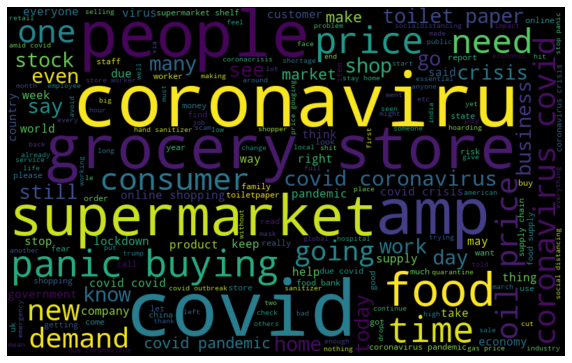

In [34]:
# create text from just normal tweets
negative_words = ' '.join([text for text in vis_df['Tweet'][vis_df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

> **We see that due to lockdowns and all people are panic buying and this term is associated with supermarket and grocery store**

> **We are also seeing tweets about consumer, prices, demand and supply, about food, stock, time**

**▶ Neutral Words**

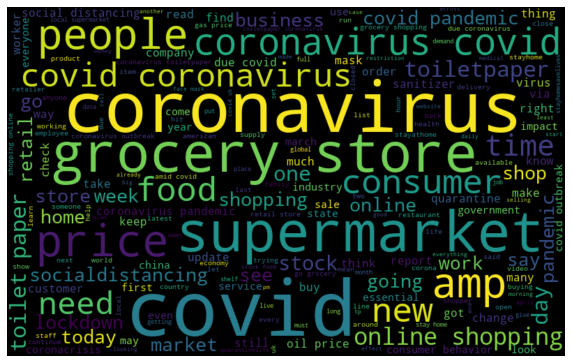

In [35]:
# create text from just normal tweets
neutral_words = ' '.join([text for text in vis_df['Tweet'][vis_df['Sentiment'] == 'Neutral']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**▶ Finding HashTags used**

In [36]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [37]:
# extracting hashtags from non racist/sexist tweets
HT_Extremely_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Positive'])
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])
HT_Extremely_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Negative'])

In [38]:
HT_Extremely_Positive

[[],
 ['horningsea'],
 [],
 ['COVID2019',
  'Trials',
  'Monthly',
  'Yearly',
  'Prices',
  'Subscriptions',
  'bestiptv',
  'iptv',
  'Service',
  'Iptv',
  'iptvdeals',
  'Cheap',
  'ipTV',
  'Football',
  'HD',
  'Movies',
  'Adult',
  'Cinema',
  'hotmovies',
  'iptvnew',
  'iptv2020',
  'Adult'],
 ['COVID2019',
  'Trials',
  'Monthly',
  'Yearly',
  'Prices',
  'Subscriptions',
  'bestiptv',
  'iptv',
  'Service',
  'Iptv',
  'iptvdeals',
  'Cheap',
  'ipTV',
  'Football',
  'HD',
  'Movies',
  'Adult',
  'Cinema',
  'hotmovies',
  'ipTv',
  '18Movies'],
 ['consumer', 'covid19', 'tracker'],
 ['BreakingNews',
  'Breaking',
  'Coronavirus',
  'CoronavirusOutbreak',
  'COVID19',
  'COVID',
  'COVID_19',
  'COVID2019',
  'Collapse'],
 ['CoronavirusOutbreak', 'coronavirus', 'COVID2019'],
 ['jlmco',
  'jlmcobrand',
  'coronapocolypse',
  'coronavirus',
  'CoronavirusOutbreak',
  'COVID19',
  'shoponline'],
 [],
 ['coronavirus',
  'COVID19',
  'peoplearelosingtheirminds',
  'StopTheMadn

In [39]:
# unnesting list
HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])
HT_Extremely_Negative = sum(HT_Extremely_Negative,[])

In [40]:
HT_Extremely_Positive

['horningsea',
 'COVID2019',
 'Trials',
 'Monthly',
 'Yearly',
 'Prices',
 'Subscriptions',
 'bestiptv',
 'iptv',
 'Service',
 'Iptv',
 'iptvdeals',
 'Cheap',
 'ipTV',
 'Football',
 'HD',
 'Movies',
 'Adult',
 'Cinema',
 'hotmovies',
 'iptvnew',
 'iptv2020',
 'Adult',
 'COVID2019',
 'Trials',
 'Monthly',
 'Yearly',
 'Prices',
 'Subscriptions',
 'bestiptv',
 'iptv',
 'Service',
 'Iptv',
 'iptvdeals',
 'Cheap',
 'ipTV',
 'Football',
 'HD',
 'Movies',
 'Adult',
 'Cinema',
 'hotmovies',
 'ipTv',
 '18Movies',
 'consumer',
 'covid19',
 'tracker',
 'BreakingNews',
 'Breaking',
 'Coronavirus',
 'CoronavirusOutbreak',
 'COVID19',
 'COVID',
 'COVID_19',
 'COVID2019',
 'Collapse',
 'CoronavirusOutbreak',
 'coronavirus',
 'COVID2019',
 'jlmco',
 'jlmcobrand',
 'coronapocolypse',
 'coronavirus',
 'CoronavirusOutbreak',
 'COVID19',
 'shoponline',
 'coronavirus',
 'COVID19',
 'peoplearelosingtheirminds',
 'StopTheMadness',
 'stoppanicbuying',
 'coronavirus',
 'StopPanicBuying',
 'BeKind',
 'mufc',
 '

In [41]:
# making frequency distribution top 10 Extremely Positive hashtags
a1 = nltk.FreqDist(HT_Extremely_Positive)
d1 = pd.DataFrame({'Hashtag': list(a1.keys()),
                  'Count' : list(a1.values())})

d1 = d1.nlargest(columns = 'Count', n = 10)


# making frequency distribution top 10 Positive hashtags
a2 = nltk.FreqDist(HT_Positive)
d2 = pd.DataFrame({'Hashtag': list(a2.keys()),
                  'Count' : list(a2.values())})

d2 = d2.nlargest(columns = 'Count', n = 10)


# making frequency distribution top 10 Neutral hashtags
a3 = nltk.FreqDist(HT_Neutral)
d3 = pd.DataFrame({'Hashtag': list(a3.keys()),
                  'Count' : list(a3.values())})

d3 = d3.nlargest(columns = 'Count', n = 10)


# making frequency distribution top 10 Negative hashtags
a4 = nltk.FreqDist(HT_Negative)
d4 = pd.DataFrame({'Hashtag': list(a4.keys()),
                  'Count' : list(a4.values())})

d4 = d4.nlargest(columns = 'Count', n = 10)


# making frequency distribution top 10 Extremely Negative hashtags
a5 = nltk.FreqDist(HT_Extremely_Negative)
d5 = pd.DataFrame({'Hashtag': list(a5.keys()),
                  'Count' : list(a5.values())})

d5 = d5.nlargest(columns = 'Count', n = 10)

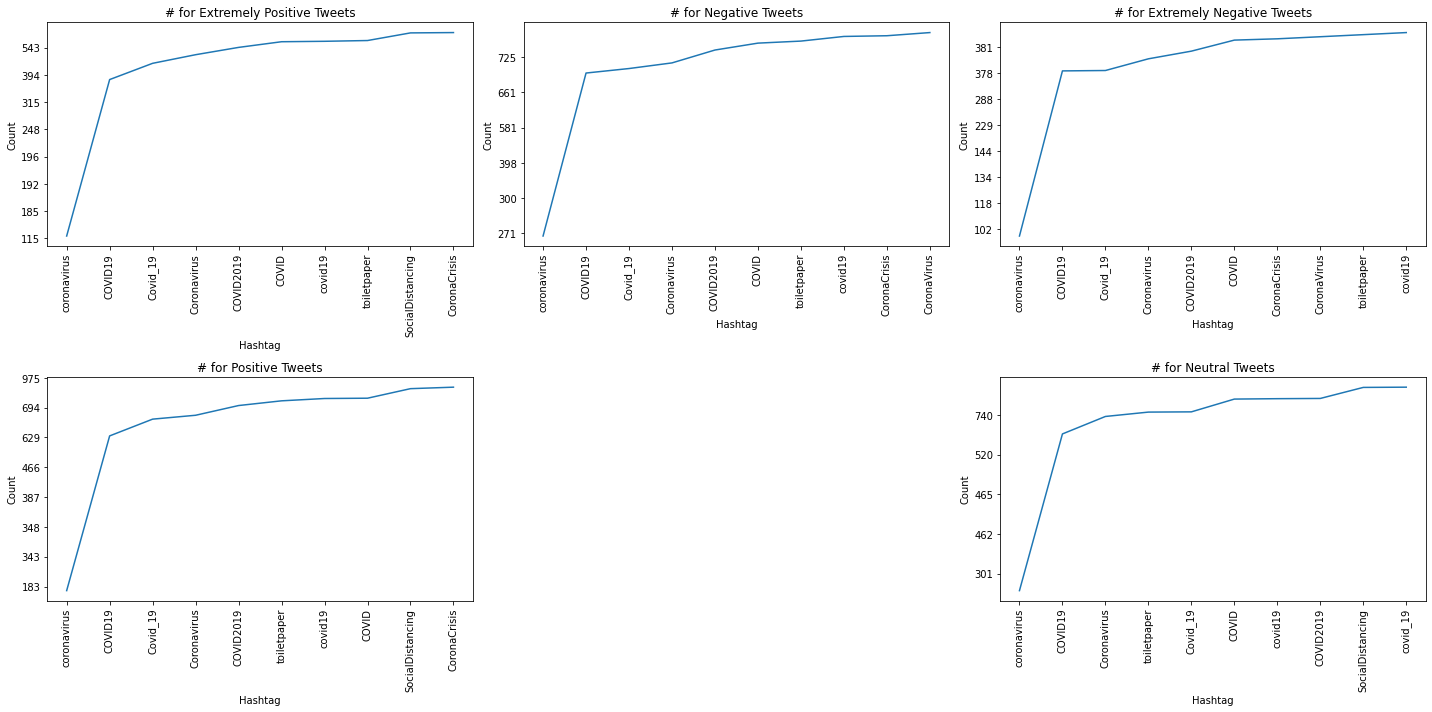

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# plot time signal:
axs[0, 0].set_title("# for Extremely Positive Tweets")
axs[0, 0].plot(d1['Hashtag'], d1['Count'])
axs[0, 0].set_xlabel('Hashtag')
axs[0, 0].set_ylabel("Count")
axs[0, 0].tick_params(labelrotation=90)
axs[0, 0].set_yticklabels(d1['Count'], rotation=0)
axs[0, 0].invert_yaxis()

# plot different spectrum types:
axs[1, 0].set_title("# for Positive Tweets")
axs[1, 0].plot(d2['Hashtag'], d2['Count'])
axs[1, 0].set_xlabel('Hashtag')
axs[1, 0].set_ylabel("Count")
axs[1, 0].tick_params(labelrotation=90)
axs[1, 0].set_yticklabels(d2['Count'], rotation=0)
axs[1, 0].invert_yaxis()

axs[1, 2].set_title("# for Neutral Tweets")
axs[1, 2].plot(d3['Hashtag'], d3['Count'])
axs[1, 2].set_xlabel('Hashtag')
axs[1, 2].set_ylabel("Count")
axs[1, 2].tick_params(labelrotation=90)
axs[1, 2].set_yticklabels(d3['Count'], rotation=0)
axs[1, 2].invert_yaxis()

axs[0, 1].set_title("# for Negative Tweets")
axs[0, 1].plot(d4['Hashtag'], d4['Count'])
axs[0, 1].set_xlabel('Hashtag')
axs[0, 1].set_ylabel("Count")
axs[0, 1].tick_params(labelrotation=90)
axs[0, 1].set_yticklabels(d4['Count'], rotation=0)
axs[0, 1].invert_yaxis()

axs[0, 2].set_title("# for Extremely Negative Tweets")
axs[0, 2].plot(d5['Hashtag'], d5['Count'])
axs[0, 2].set_xlabel('Hashtag')
axs[0, 2].set_ylabel("Count")
axs[0, 2].tick_params(labelrotation=90)
axs[0, 2].set_yticklabels(d5['Count'], rotation=0)
axs[0, 2].invert_yaxis()

axs[1, 1].remove()  # don't display empty ax

fig.tight_layout()
plt.show()

### **▶ Data Visualization for Unique Values**

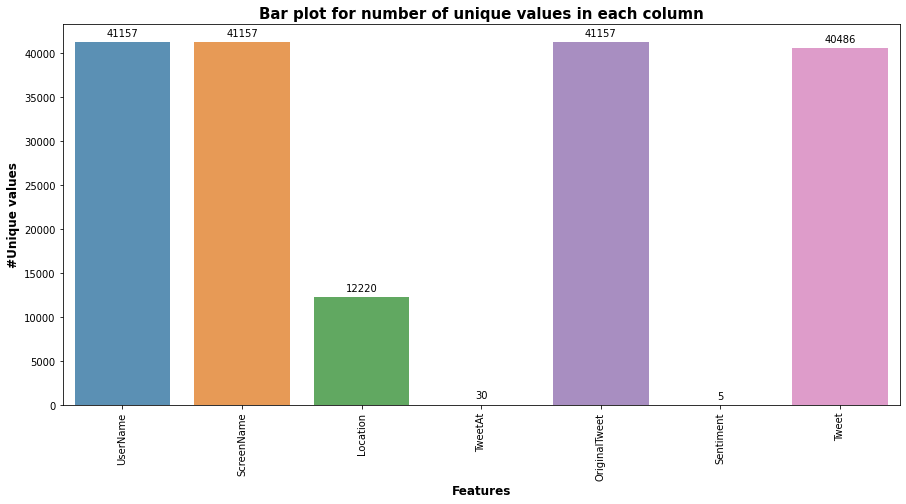

In [43]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

### **▶ Data Visualization for Location**

In [44]:
import plotly.graph_objects as go

In [45]:
loc_analysis = pd.DataFrame(df['Location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'Location':'count'})

In [46]:
data = {
   "values": loc_analysis['count'][:15],
   "labels": loc_analysis.index[:15],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

In [47]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

In [48]:
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)

[Text(0, 0, 'London'),
 Text(0, 0, 'United States'),
 Text(0, 0, 'London, England'),
 Text(0, 0, 'New York, NY'),
 Text(0, 0, 'Washington, DC'),
 Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Los Angeles, CA'),
 Text(0, 0, 'India'),
 Text(0, 0, 'UK'),
 Text(0, 0, 'Australia')]

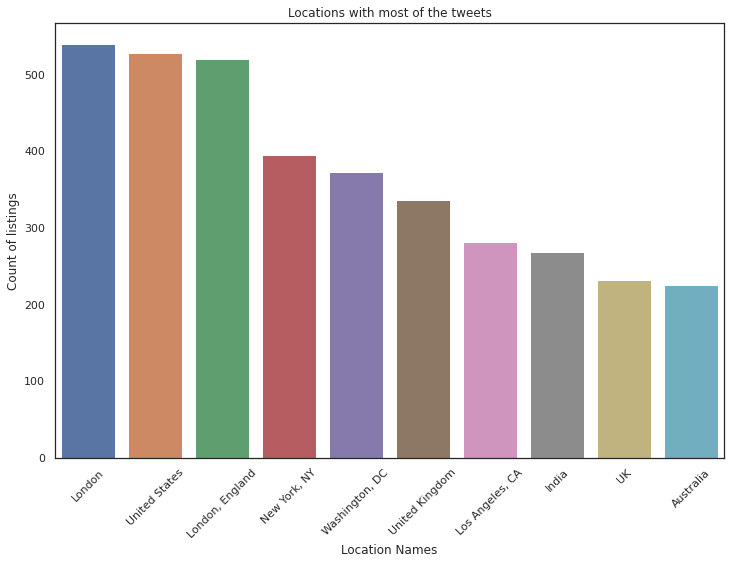

In [49]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df)
viz_1.set_title('Locations with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

### **▶ Visualization for TweetAt**

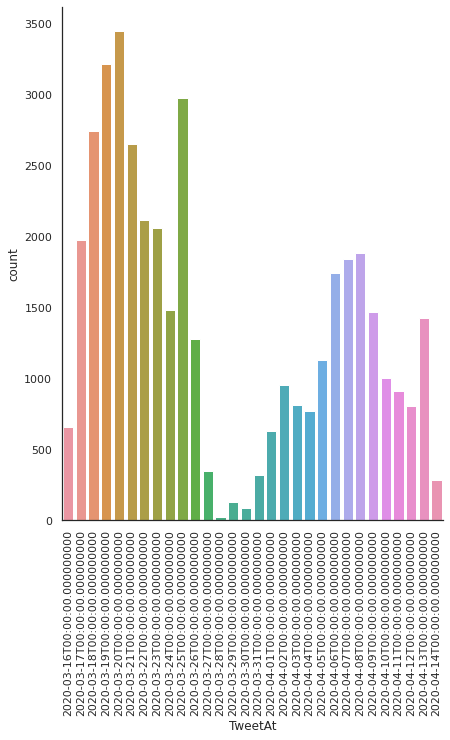

In [50]:
fig = sns.catplot("TweetAt", data=df, kind="count", height=8)
fig.set_xticklabels(rotation=90)
plt.show()

### **▶ Visualization for Twitter Sentiments**

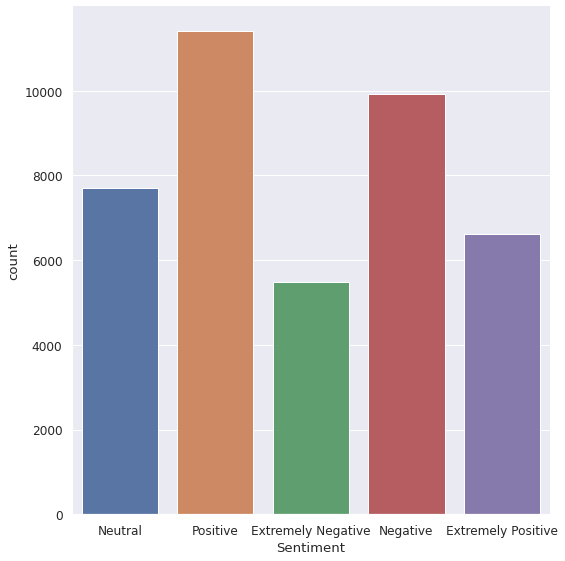

In [51]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=8)

## ***Text Representation and Feature Engineering***

In [52]:
new_df = df[['Tweet','Sentiment']]

In [53]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) 
#stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


### **▶ Count Vectorizer**

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_cv = vectorizer.fit_transform(train.Tweet.values)
X_valid_cv = vectorizer.transform(valid.Tweet.values)

y_train_cv = train.Sentiment.values
y_valid_cv = valid.Sentiment.values

print("X_train.shape : ", X_train_cv.shape)
print("X_valid.shape : ", X_valid_cv.shape)
print("y_train.shape : ", y_train_cv.shape)
print("y_valid.shape : ", y_valid_cv.shape)

X_train.shape :  (32925, 33177)
X_valid.shape :  (8232, 33177)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


In [ ]:
print(X_train_cv)

### **▶ TF-IDF Vectorizer**

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(train.Tweet.values)
X_valid_tfidf = vectorizer.transform(valid.Tweet.values)

y_train_tfidf = train.Sentiment.values
y_valid_tfidf = valid.Sentiment.values

print("X_train.shape : ", X_train_tfidf.shape)
print("X_valid.shape : ", X_valid_tfidf.shape)
print("y_train.shape : ", y_train_tfidf.shape)
print("y_valid.shape : ", y_valid_tfidf.shape)

X_train.shape :  (32925, 33177)
X_valid.shape :  (8232, 33177)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


In [ ]:
print(X_train_tfidf)

In [ ]:
# feature_names = vectorizer.get_feature_names()
# matrix = X_train_tfidf.todense()
# list_dense = matrix.tolist()

In [ ]:
# tfidf_df = pd.DataFrame(list_dense, columns = feature_names)
# tfidf_df.head()